### Paid Search Bid Optimization 

Question on Paid Search Bid Optimization(There are 4 parts )

A travel services firm has a paid search campaign. Among the many keywords in its campaign, we have data on four keywords, denoted by kw8322228, kw8322392, kw8322393 and kw8322445. These are generic, non-branded keywords, where the prospect's query does not indicate that he/she is leaning toward a specific brand. For each keyword, the firm tried several bid values and recorded the corresponding number of clicks that it received!

_**Note: Alpha should be between 70 and 76, beta should between 0.03 and 0.06, with a residual-sum-of-squares of about 230.**_

Step1: Estimate the alpha and beta for a keyword - you need to nonlinear regression. Curve fitting through scipy.optimize.curve_fit.

Step2:

In [1]:
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from flax import linen as nn
from functools import partial
from jax import value_and_grad
from sklearn.metrics import root_mean_squared_error
ClStreamD01pd=pd.read_csv("./Data/clicksdata.kw8322228.csv")
ClStreamD02pd=pd.read_csv("./Data/clicksdata.kw8322392.csv")
ClStreamD03pd=pd.read_csv("./Data/clicksdata.kw8322393.csv")
ClStreamD04pd=pd.read_csv("./Data/clicksdata.kw8322445.csv")
alphSeries = jnp.linspace(90,100,20)
betaeries = jnp.linspace(0,0.5,100)
# ClStreamD01.head(10)
ClStreamD01=jnp.array(ClStreamD01pd)
ClStreamD01=ClStreamD01[:,1:3]
ClStreamD02=jnp.array(ClStreamD02pd)
ClStreamD02=ClStreamD02[:,1:3]
ClStreamD03=jnp.array(ClStreamD03pd)
ClStreamD03=ClStreamD03[:,1:3]
ClStreamD04=jnp.array(ClStreamD04pd)
ClStreamD04=ClStreamD04[:,1:3]
ClStreamD01,ClStreamD02,ClStreamD03,ClStreamD04

Metal device set to: Apple M3 Pro

systemMemory: 18.00 GB
maxCacheSize: 6.00 GB



W0000 00:00:1745045806.600647  268787 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1745045806.610427  268787 service.cc:145] XLA service 0x174b25360 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745045806.610434  268787 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1745045806.611550  268787 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1745045806.611558  268787 mps_client.cc:384] XLA backend will use up to 12884443136 bytes on device 0 for SimpleAllocator.


(Array([[ 5.58, 15.  ],
        [ 8.04, 24.  ],
        [10.77, 25.  ],
        [13.83, 30.  ],
        [17.33, 46.  ],
        [21.39, 38.  ],
        [26.25, 40.  ],
        [32.27, 50.  ],
        [40.24, 65.  ]], dtype=float32),
 Array([[  1.44,  30.  ],
        [  2.07,  45.  ],
        [  2.78,  60.  ],
        [  3.57,  75.  ],
        [  4.47,  66.  ],
        [  5.52,  83.  ],
        [  6.77,  98.  ],
        [  8.33, 106.  ],
        [ 10.38, 131.  ]], dtype=float32),
 Array([[ 3.28, 17.  ],
        [ 4.73, 33.  ],
        [ 6.34, 42.  ],
        [ 8.14, 57.  ],
        [10.19, 51.  ],
        [12.58, 68.  ],
        [15.44, 81.  ],
        [18.99, 78.  ],
        [23.67, 88.  ]], dtype=float32),
 Array([[  0.53,  32.  ],
        [  0.76,  60.  ],
        [  1.01,  76.  ],
        [  1.3 ,  86.  ],
        [  1.63,  97.  ],
        [  2.01, 101.  ],
        [  2.47, 113.  ],
        [  3.04, 131.  ],
        [  3.79, 163.  ]], dtype=float32))

#### Answer Q3.A

In [2]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
from tqdm import tqdm

LEARNINGRATE=0.001
BATCHSIZE=32
EPOCHS=1000

# ✅ Define model
class SaturationModel(nn.Module):
    def __call__(self, x, alpha, beta):
        return alpha * (1 - jnp.exp(-beta * x))

def fitCurve(x_true,y_true,alphaStart,alphaEnd,BetaStart,BetaEnd):
    # 🎯 Replace these with your actual data
    bid_value = x_true #ClStreamD01[:,0]
    n_clicks_true = y_true #ClStreamD01[:,1]

    # ✅ Define model
    class SaturationModel(nn.Module):
        def __call__(self, x, alpha, beta):
            return alpha * (1 - jnp.exp(-beta * x))

    # ✅ Loss and train_step
    def loss_fn(params, x, y_true):
        y_pred = SaturationModel().apply({}, x, params['alpha'], params['beta'])
        return jnp.sqrt(jnp.mean((y_true - y_pred) ** 2))

    @jax.jit
    def train_step(params, opt_state, x, y_true):
        loss, grads = jax.value_and_grad(loss_fn)(params, x, y_true)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, loss

    # ✅ Grid search ranges
    alpha_range =jnp.linspace(alphaStart,alphaEnd,num=20) #jnp.linspace(70, 90, num=20)
    beta_range = jnp.linspace(BetaStart, BetaEnd, num=20) # jnp.linspace(0.0, 0.5, num=20)

    results = []

    # ✅ Optimizer config
    lr = LEARNINGRATE
    optimizer = optax.adam(learning_rate=lr)

    # 🔁 Grid search loop
    for alpha_init in tqdm(alpha_range, desc="Alpha Loop"):
        for beta_init in beta_range:
            # Initialize parameters
            params = {
                'alpha': alpha_init,
                'beta': beta_init
            }
            opt_state = optimizer.init(params)

            # Train for 3000 epochs
            for epoch in range(EPOCHS):
                params, opt_state, loss = train_step(params, opt_state, bid_value, n_clicks_true)

            # Save result
            results.append({
                'alpha_init': float(alpha_init),
                'beta_init': float(beta_init),
                'final_loss': float(loss),
                'alpha_final': float(params['alpha']),
                'beta_final': float(params['beta'])
            })

    # ✅ Sort by lowest loss
    results = sorted(results, key=lambda x: x['final_loss'])

    # 🔍 Print best result
    best = results[0]
    print("\n✅ Best Fit Found")
    print(f"Initial α: {best['alpha_init']}, Initial β: {best['beta_init']}")
    print(f"Final α: {best['alpha_final']:.4f}, Final β: {best['beta_final']:.4f}, Loss: {best['final_loss']:.6f}")
    return best

def plotChart(bidVal,nClicksTrue,alpha,beta,num=1):
    y_pred = SaturationModel().apply({}, bidVal, alpha, beta)
    print(f'RMSE {root_mean_squared_error(y_true=nClicksTrue, y_pred=y_pred)}')
    plt.figure(figsize=(8, 5))
    # plt.scatter(bid_value, n_clicks_noisy, label="Noisy Clicks", alpha=0.4)
    plt.plot(bidVal, nClicksTrue, '--', label="True Curve")
    plt.plot(bidVal, y_pred, label="Fitted Curve (Flax)", color="red", linewidth=2)
    plt.legend()
    plt.xlabel("Bid Value")
    plt.ylabel("N Clicks")
    plt.title(f"Curve Fitting: α(1 - exp(-β * bid)) for  dataset {num}")
    plt.grid(True)
    plt.show()

In [3]:
X_true=ClStreamD01[:,0]
Y_true=ClStreamD01[:,1]
AlphaStart,AlphaEnd=70,90
BetaStart,BetaEnd=0,0.5
Result01=fitCurve(X_true,Y_true,AlphaStart,AlphaEnd,BetaStart,BetaEnd)

Alpha Loop: 100%|██████████| 20/20 [01:07<00:00,  3.40s/it]


✅ Best Fit Found
Initial α: 74.21052551269531, Initial β: 0.21052631735801697
Final α: 74.0858, Final β: 0.0395, Loss: 5.053214


#### The Fitted Curve for kw8322228

RMSE 5.053213596343994


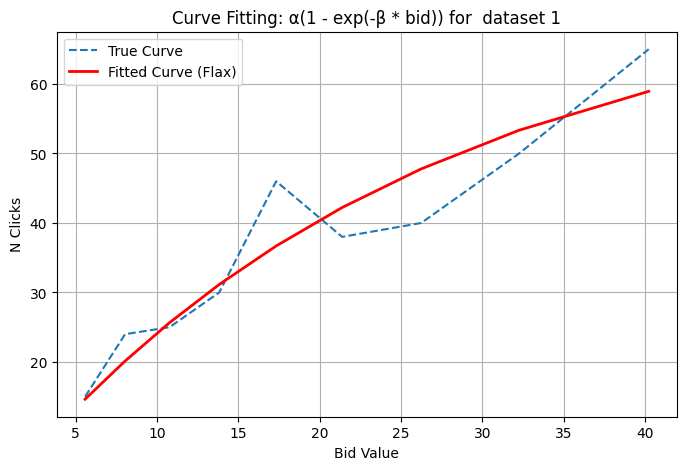

In [4]:
X_true=ClStreamD01[:,0]
Y_true=ClStreamD01[:,1]
plotChart(X_true,Y_true,Result01['alpha_final'],Result01['beta_final'])

In [5]:
X_true=ClStreamD02[:,0]
Y_true=ClStreamD02[:,1]
AlphaStart,AlphaEnd=90,100
BetaStart,BetaEnd=0,0.5
Result02=fitCurve(X_true,Y_true,AlphaStart,AlphaEnd,BetaStart,BetaEnd)

Alpha Loop: 100%|██████████| 20/20 [01:10<00:00,  3.50s/it]


✅ Best Fit Found
Initial α: 100.0, Initial β: 0.42105263471603394
Final α: 101.1043, Final β: 0.3314, Loss: 13.146878


#### The Fitted Curve for kw8322392

RMSE 13.14657211303711


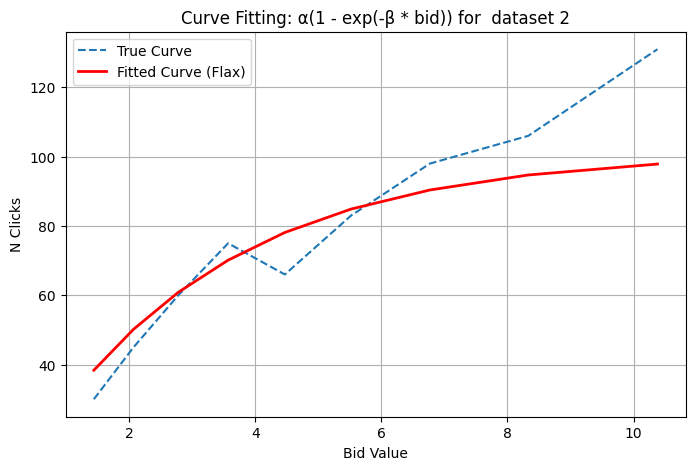

In [6]:
X_true=ClStreamD02[:,0]
Y_true=ClStreamD02[:,1]
plotChart(X_true,Y_true,Result02['alpha_final'],Result02['beta_final'],2)

In [7]:
X_true=ClStreamD03[:,0]
Y_true=ClStreamD03[:,1]
AlphaStart,AlphaEnd=70,90
BetaStart,BetaEnd=0,0.5
Result03=fitCurve(X_true,Y_true,AlphaStart,AlphaEnd,BetaStart,BetaEnd)

Alpha Loop: 100%|██████████| 20/20 [01:09<00:00,  3.50s/it]


✅ Best Fit Found
Initial α: 90.0, Initial β: 0.10526315867900848
Final α: 90.9805, Final β: 0.1031, Loss: 5.637787


#### The fitted curve for  kw8322393

RMSE 5.637672424316406


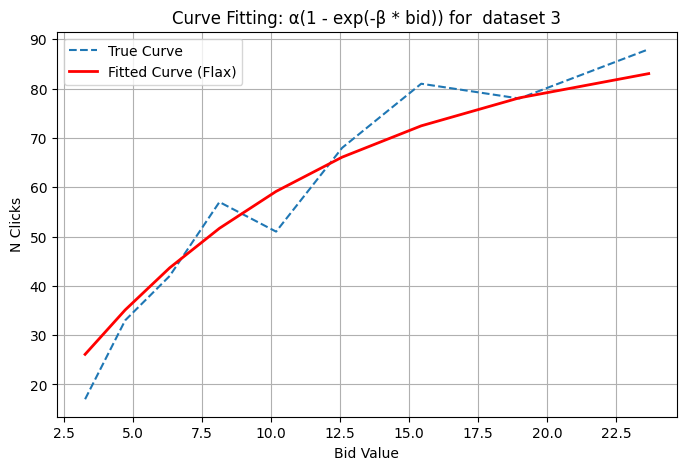

In [8]:
X_true=ClStreamD03[:,0]
Y_true=ClStreamD03[:,1]
plotChart(X_true,Y_true,Result03['alpha_final'],Result03['beta_final'],3)

#### The fitted curve for keyword kw8322445

Alpha Loop: 100%|██████████| 20/20 [01:12<00:00,  3.65s/it]


✅ Best Fit Found
Initial α: 90.0, Initial β: 0.5
Final α: 91.0318, Final β: 1.1437, Loss: 32.092983
RMSE 32.08858108520508


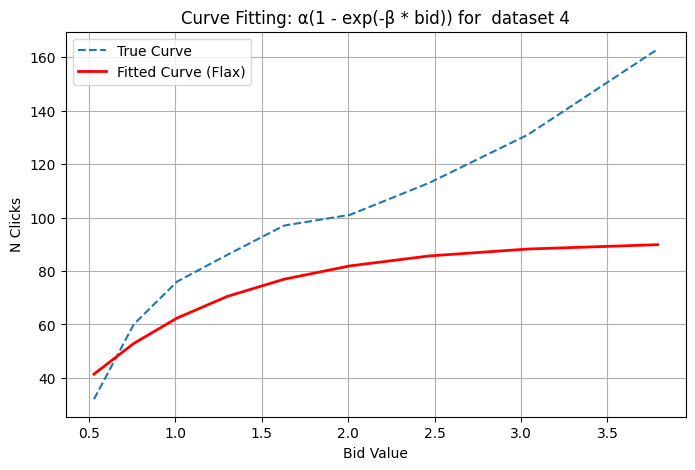

In [9]:
X_true=ClStreamD04[:,0]
Y_true=ClStreamD04[:,1]
AlphaStart,AlphaEnd=70,90
BetaStart,BetaEnd=0,0.5
Result04=fitCurve(X_true,Y_true,AlphaStart,AlphaEnd,BetaStart,BetaEnd)
X_true=ClStreamD04[:,0]
Y_true=ClStreamD04[:,1]
plotChart(X_true,Y_true,Result04['alpha_final'],Result04['beta_final'],4)

#### Answer to Question 3.B

  `Expected Profit per Click = LTV * ConversionRate - b`

The expected profit per click is the expected lifetime value of a customer multiplied by the conversion rate, minus

 `Profit Overall(b) = Number of clicks(b) ×Expected Profit/Click(b)`

|keyword|ltv|Conv.rate|
| --- | --- | --- |
|kw8322228|354|0.3|
|kw8322392|181|0.32|
|kw8322393|283|0.3|
|kw8322445|107|0.35|

`Expenditure(b) = b×Number of clicks(b) = b×α(1−exp(−βb))`

In [10]:
alphalst=[74.0858,101.1043,90.9805,91.0318]
betalst=[0.0395,0.3314,0.1031,1.1437]
LTVLst=[354,181,283,107]
ConvRate1 =[0.3,0.32,0.3,0.35]

In [11]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# Constants (you can adjust these)
def Optbid(alpha,beta,ltv,conversion_rate):
    # alpha = 100.0
    # beta = 0.8
    # ltv = 500.0
    # conversion_rate = 0.02

    # Profit Function: Profit(bid)
    def profit_fn(bid):
        clicks = alpha * (1 - jnp.exp(-beta * bid))
        value = ltv * conversion_rate - bid
        return clicks * value

    # Since we want to MAXIMIZE profit, we MINIMIZE negative profit
    def neg_profit(bid):
        return -profit_fn(bid)

    #Initialize bid value (start point)
    bid = jnp.array(0.05)
    optimizer = optax.adam(learning_rate=0.1)
    opt_state = optimizer.init(bid)

    @jax.jit
    def optimization_step(bid, opt_state):
        loss, grad = jax.value_and_grad(neg_profit)(bid)
        updates, opt_state = optimizer.update(grad, opt_state)
        bid = optax.apply_updates(bid, updates)
        return bid, opt_state, -loss  # return profit

    profits = []
    bids = []

    for epoch in range(8000):
        bid, opt_state, profit = optimization_step(bid, opt_state)
        bids.append(float(bid))
        profits.append(float(profit))
    
    # Convert optimization history to DataFrame
    df_plot = pd.DataFrame({
        'Bid': bids,
        'Profit': profits
    })

    print(f"\n✅ Optimal Bid: {float(bid):.4f}")
    print(f"📈 Max Profit: {float(profit):.4f}")
    return df_plot

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd


def plotPlotly(df_plot):
    # Identify optimal values
    optimal_index = df_plot['Profit'].idxmax()
    optimal_bid = df_plot.loc[optimal_index, 'Bid']
    optimal_profit = df_plot.loc[optimal_index, 'Profit']

    # Plot using Plotly
    fig = px.line(
        df_plot,
        x='Bid',
        y='Profit',
        title='📈 Bid Optimization: Profit vs. Bid',
        markers=True,
        labels={'Bid': 'Bid Value', 'Profit': 'Profit'}
    )

    # Add vertical line at optimal bid
    fig.add_vline(
        x=optimal_bid,
        line_dash="dash",
        line_color="red",
        annotation_text=f"Optimal Bid = {optimal_bid:.2f}",
        annotation_position="top left"
    )

    # Add horizontal line at max profit
    fig.add_hline(
        y=optimal_profit,
        line_dash="dot",
        line_color="green",
        annotation_text=f"Max Profit = {optimal_profit:.2f}",
        annotation_position="bottom right"
    )

    # Style
    fig.update_layout(template='plotly_white')
    fig.show()

for item in zip(alphalst,betalst,LTVLst,ConvRate1):
    bidDf=Optbid(alpha=item[0],
           beta=item[1],
           ltv=item[2],
           conversion_rate=item[3])
    plotPlotly(bidDf)
    


✅ Optimal Bid: 34.1119
📈 Max Profit: 3952.6018



✅ Optimal Bid: 8.6093
📈 Max Profit: 4698.0386



✅ Optimal Bid: 19.8118
📈 Max Profit: 5153.7559



✅ Optimal Bid: 3.2284
📈 Max Profit: 3037.6401


##### Above charts are related to four keyword optimized bids for four keywords kw8322228, kw8322392, kw8322393, kw8322445

In [17]:
Optimal_Bids= [34.1119,8.6093,19.8118,3.2284]
Profits=[ 3952.6018,4698.0386,5153.7559,3037.6401]
BidDF=pd.DataFrame([Optimal_Bids,Profits],columns=['kw8322228','kw8322392','kw8322393','kw8322445'],index=['Optimal Bid','Profit'])
BidDF.T

,Optimal Bid,Profit
kw8322228,34.1119,3952.6018
kw8322392,8.6093,4698.0386
kw8322393,19.8118,5153.7559
kw8322445,3.2284,3037.6401


##### Answer 3.C -- Simulating to find budget allocation

In [18]:
import jax
import jax.numpy as jnp
import optax
import pandas as pd

# Constants for each keyword
keywords = ['kw8322228', 'kw8322392', 'kw8322393', 'kw8322445']
alpha = jnp.array([74.0858, 101.1043, 90.9805, 91.0318])
beta = jnp.array([0.0395, 0.3314, 0.1031, 1.1437])
ltv = jnp.array([354.0, 181.0, 283.0, 107.0])
cr = jnp.array([0.3, 0.32, 0.3, 0.35])
TOTAL_BUDGET = 3000.0

# Objective: Total profit = clicks × (LTV × CR − bid)
def compute_profit(bids):
    clicks = alpha * (1 - jnp.exp(-beta * bids))
    value = ltv * cr - bids
    return jnp.sum(clicks * value)

# Cost constraint = sum(bid * clicks)
def compute_cost(bids):
    clicks = alpha * (1 - jnp.exp(-beta * bids))
    return jnp.sum(bids * clicks)

# Initialize bids with a starting point (e.g., mid-range)
init_bids = jnp.array([5.0, 5.0, 5.0, 5.0])
optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(init_bids)

@jax.jit
def step(bids, opt_state):
    loss_fn = lambda b: -compute_profit(b)
    grads = jax.grad(loss_fn)(bids)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_bids = optax.apply_updates(bids, updates)

    # Projection step to respect total cost constraint
    total_cost = compute_cost(new_bids)
    scale = jnp.minimum(1.0, TOTAL_BUDGET / (total_cost + 1e-8))
    return new_bids * scale, opt_state

# Run optimization
bids = init_bids
for _ in range(5000):
    bids, opt_state = step(bids, opt_state)

# Final metrics
clicks = alpha * (1 - jnp.exp(-beta * bids))
profit = clicks * (ltv * cr - bids)
cost = clicks * bids

# Create result DataFrame
df = pd.DataFrame({
    'Keyword': keywords,
    'Optimized Bid': bids,
    'Clicks': clicks,
    'Cost': cost,
    'Profit': profit,
    '% of Budget': cost / TOTAL_BUDGET * 100
})

print(df.round(2))
print("\nTotal Cost:", cost.sum().round(2), "| Total Profit:", profit.sum().round(2))

     Keyword  Optimized Bid     Clicks         Cost       Profit  % of Budget
0  kw8322228      18.010000  37.709999   679.049988  3325.669922    22.639999
1  kw8322392       8.560000  95.180000   814.659973  4697.990234    27.160000
2  kw8322393      16.370001  74.150002  1213.589966  5081.700195    40.450001
3  kw8322445       3.230000  88.760002   286.440002  3037.639893     9.550000

Total Cost: 2993.74 | Total Profit: 16143.0
